In [21]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

from models.lm import LM
from models.transformer.transformer import TransformerConfig

from data import OthelloDataset

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
d_model = 16
n_layers = 1
n_heads = 8

B = 1

In [4]:
ds = OthelloDataset()
loader = torch.utils.data.DataLoader(ds, batch_size=B, num_workers=0, pin_memory=True)

In [18]:
config = TransformerConfig(d_model=d_model, n_layers=n_layers, n_heads=n_heads, max_len=60)
model = LM(config, vocab_size=65).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [19]:
losses = []

In [25]:
for i, data in enumerate(loader):
    x, y = data
    x, y = x+1, y+1 # todo : change dataset
    x = x.int().to(device)
    y = y.long().to(device)

    logits = model(x)
    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=0) # todo : move loss

    losses.append(loss.item())

    optim.zero_grad()
    loss.backward()
    optim.step()

    if i >= 500:
        break

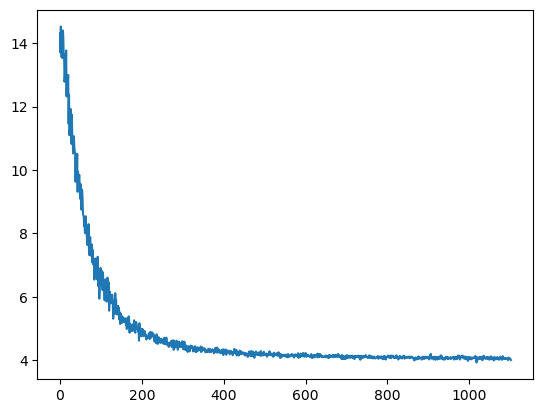

In [32]:
plt.plot(losses)
